<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group: Assignment 1 28

Authors: Medha Hegde (1592718), Gergely Szakállas (1608428)

In [1]:
import requests
import io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

train_x shape: (18800, 28, 28)
train_y shape: (18800,)



### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [3]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)

print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


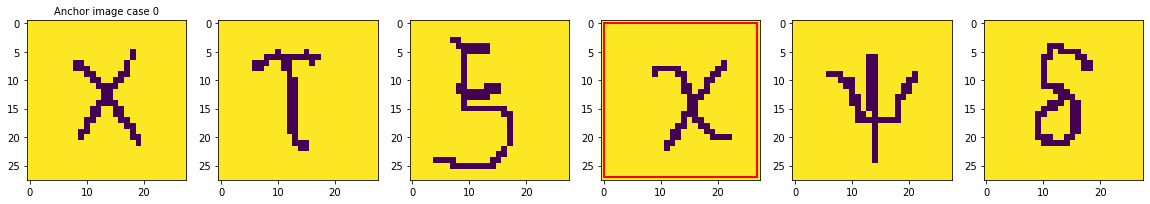

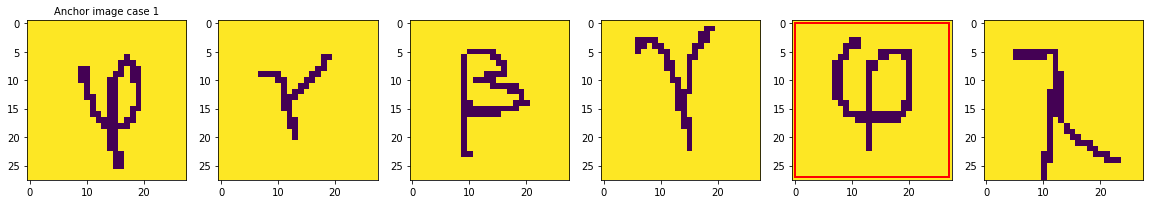

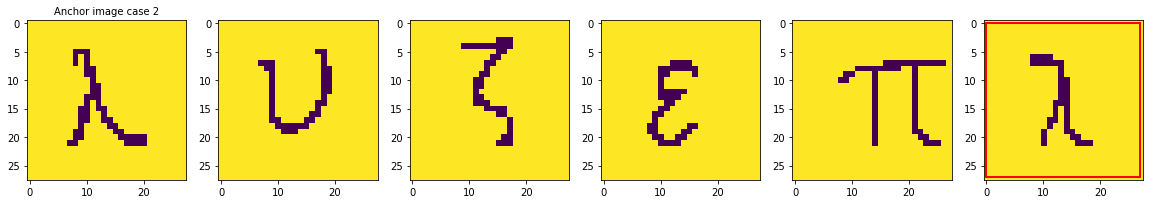

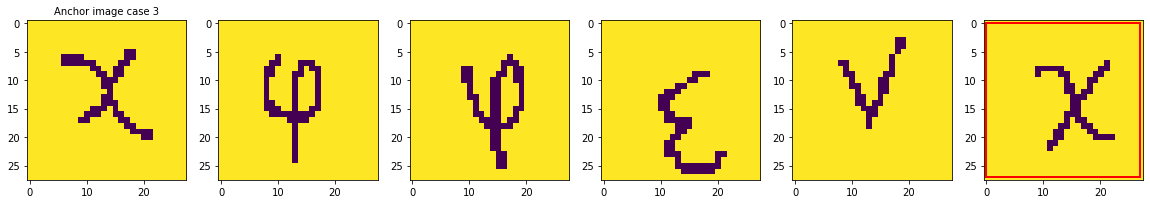

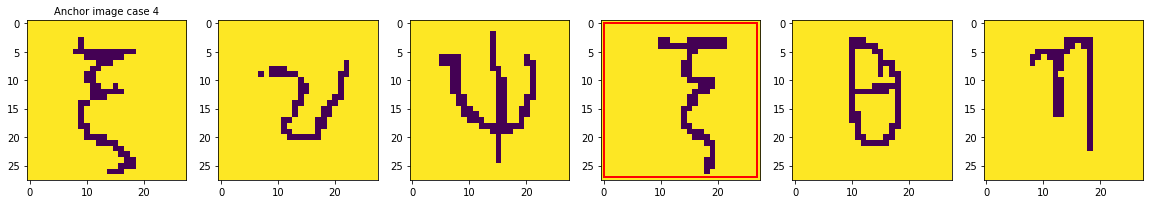

In [4]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import random
from collections import defaultdict

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Group training samples by labels
x_by_y = defaultdict(list)
for x, y in zip(train_x, train_y):
    x_by_y[y].append(x)

# Iterate over all samples and for each add all positive pairs + N negative pairs (defined above)
total_len = len(train_y)
gen_x, gen_y = ([],[]), []
for y, xs in x_by_y.items():
    for n, x1 in enumerate(xs):
        while True:
            # Pick random positive and negative samples
            m = random.randrange(len(xs))
            ce = random.randrange(total_len)
            if n != m and train_y[ce] != y:
                # Success, the picked characters are of the right classes
                gen_x[0].append(x1)
                gen_x[1].append(xs[m])
                gen_y.append([1.0])
                gen_x[0].append(x1)
                gen_x[1].append(train_x[ce])
                gen_y.append([0.0])
                break

# Generate dataset representing pairs of images and whether they are representing the same character (1.0) or not (0.0)
dataset = TensorDataset(torch.from_numpy(np.array(gen_x[0], dtype=np.float32)).to(device), torch.from_numpy(np.array(gen_x[1], dtype=np.float32)).to(device), torch.tensor(gen_y).to(device))
# Generate dataloaders for train and validation sets split in 80-20% ratio
size = len(gen_y)
train_size = int(0.8*size)
train_ds, valid_ds = random_split(dataset, (train_size, size-train_size))
train_dl, valid_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(valid_ds, batch_size=batch_size*2)

In [6]:
from torch import nn
import torch.nn.functional as F

class SiameseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(1024, 1024)
        self.fcOut = nn.Linear(1024, 1)
        self.sig = nn.Sigmoid()
    
    def convs(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        return x

    def forward(self, x1, x2):
        x1 = x1.view(-1, 1, 28, 28)
        x1 = self.convs(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.sig(self.fc(x1))
        x2 = x2.view(-1, 1, 28, 28)
        x2 = self.convs(x2)
        x2 = x2.view(x2.size(0), -1)
        x2 = self.sig(self.fc(x2))
        return self.sig(self.fcOut(torch.abs(x1 - x2)))

In [7]:
from torch import optim, nn

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tl, ta, vl, va = [], [], [], []
    for epoch in range(epochs):
        # Train
        model.train()
        train_steps = 0
        total_train = len(train_dl)
        train_loss = []
        train_accuracy = []
        for x1, x2, y in train_dl:
            print(f'\rProcessing training batch {train_steps}/{total_train}...', end='')
            train_steps += 1
            # Forward
            output = model(x1, x2)
            loss = loss_func(output, y)
            train_accuracy.append(float(torch.sum(torch.round(output) == y) / len(y)))
            train_loss.append(loss.item())
            # Backward and optimize
            opt.zero_grad()
            loss.backward()
            opt.step()
        # Evaluate
        with torch.no_grad():
            model.eval()
            val_steps = 0
            total_val = len(valid_dl)
            val_loss = []
            val_accuracy = []
            for x1, x2, y in valid_dl:
                print(f'\rProcessing validation batch {val_steps}/{total_val}...', end='')
                val_steps += 1
                output = model(x1, x2)
                loss = loss_func(output, y)
                val_accuracy.append(float(torch.sum(torch.round(output) == y) / len(y)))
                val_loss.append(loss.item())
        tl.append(sum(train_loss) / total_train)
        ta.append(sum(train_accuracy) / total_train)
        vl.append(sum(val_loss) / total_val)
        va.append(sum(val_accuracy) / total_val)
        print(f'\rEpoch {epoch+1}/{epochs}, Training loss: {str(tl[-1])[:6]}, Training accuracy: {str(ta[-1])[:6]}, Validation loss: {str(vl[-1])[:6]}, Validation accuracy: {str(va[-1])[:6]}')
    return tl, ta, vl, va

epochs=3

model = SiameseModel().to(device)
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_func = nn.BCELoss()

train_loss, train_acc, val_loss, val_acc = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/3, Training loss: 0.4131, Training accuracy: 0.8051, Validation loss: 0.2980, Validation accuracy: 0.8734
Epoch 2/3, Training loss: 0.2422, Training accuracy: 0.9, Validation loss: 0.2083, Validation accuracy: 0.9141
Epoch 3/3, Training loss: 0.1875, Training accuracy: 0.9257, Validation loss: 0.1993, Validation accuracy: 0.9220


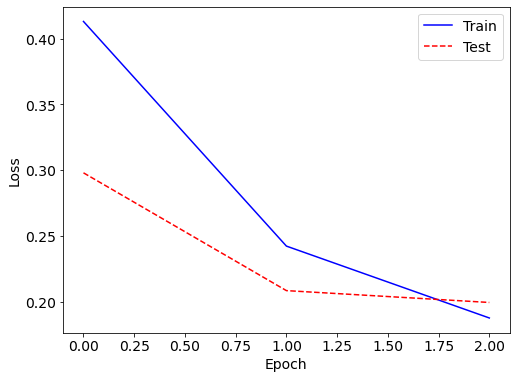

In [8]:
fs = 14
f, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(train_loss, color='blue', label='Train')
ax.plot(val_loss, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xlabel("Epoch", fontsize=fs)
ax.set_ylabel("Loss", fontsize=fs);

In [9]:
import torch
## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
  # Retrieve predictions
  outputs = model(torch.from_numpy(np.array([query] * 5, dtype=np.float32)).to(device), torch.from_numpy(np.array(candidates, dtype=np.float32)).to(device))
  # Convert, sort and return the results by predictions
  indexed_outputs = list(zip(range(1,6), outputs.reshape(-1).tolist()))
  sorted_outputs = sorted(indexed_outputs, key=lambda i: i[1], reverse=True)
  return np.array([i[0] for i in sorted_outputs])

In [10]:
## test top-1
def test_top_1(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.9
top-3 accuracy: 0.99
